## POS tagging using modified Viterbi


The vanilla Viterbi algorithm written had resulted in ~87% accuracy. The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

-Subhasis Jethy

### Data Preparation

For this assignment, you’ll use the Treebank dataset of NLTK with the 'universal' tagset. The Universal tagset of NLTK comprises only 12 coarse tag classes as follows: Verb, Noun, Pronouns, Adjectives, Adverbs, Adpositions, Conjunctions, Determiners, Cardinal Numbers, Particles, Other/ Foreign words, Punctuations.

 Note that using only 12 coarse classes (compared to the 46 fine classes such as NNP, VBD etc.) will make the Viterbi algorithm faster as well.

In [1]:
!pip install Jinja2

#Importing libraries
import nltk
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\U6083443\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05,random_state=1234)

print(f'Length of Training Set: {len(train_set)}')
print(f'Length of Test Set: {len(test_set)}')
print(train_set[:40])

Length of Training Set: 3718
Length of Test Set: 196
[[('This', 'DET'), ('year', 'NOUN'), (',', '.'), ('the', 'DET'), ('average', 'NOUN'), ('of', 'ADP'), ('daily', 'ADJ'), ('contracts', 'NOUN'), ('traded', 'VERB'), ('*', 'X'), ('totaled', 'VERB'), ('9,118', 'NUM'), (',', '.'), ('up', 'ADP'), ('from', 'ADP'), ('4,645', 'NUM'), ('a', 'DET'), ('year', 'NOUN'), ('earlier', 'ADJ'), ('and', 'CONJ'), ('from', 'ADP'), ('917', 'NUM'), ('in', 'ADP'), ('1984', 'NUM'), ('.', '.')], [('First', 'NOUN'), ('of', 'ADP'), ('America', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-1', 'X'), ('now', 'ADV'), ('has', 'VERB'), ('45', 'NUM'), ('banks', 'NOUN'), ('and', 'CONJ'), ('$', '.'), ('12.5', 'NUM'), ('billion', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('assets', 'NOUN'), (',', '.'), ('announced', 'VERB'), ('an', 'DET'), ('agreement', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('acquire', 'VERB'), ('the', 'DET'), ('Peoria', 'NOUN'), (',', '.'), ('Ill.', 'NOUN'), (',', '.'), ('bank', 'NOUN'), ('holding', 'VERB'), ('c

In [5]:
 train_tagged_words = [tup for sent in train_set for tup in sent]

In [6]:
len(train_tagged_words)

95799

In [7]:
pos_counts = collections.Counter((subl[1] for subl in train_tagged_words))
print("The five most common tags are", pos_counts.most_common(5))

The five most common tags are [('NOUN', 27471), ('VERB', 12910), ('.', 11130), ('ADP', 9387), ('DET', 8269)]


In [8]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['This',
 'year',
 ',',
 'the',
 'average',
 'of',
 'daily',
 'contracts',
 'traded',
 '*']

In [9]:
# vocabulary
V = set(tokens)
print(f'Total Words in Vocabulary: {len(V)}')

Total Words in Vocabulary: 12073


In [10]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
print(f'Total Tags : {len(T)}')

Total Tags : 12


### Build the vanilla Viterbi based POS tagger

#### Emission Probabilities

In [11]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [13]:
print(word_given_tag('Japanese','ADJ'))
print(word_given_tag('Minister','NOUN'))

# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))

(72, 6063)
(4, 27471)

 book
(7, 27471)
(1, 12910)


In [14]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [15]:
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1(t2='NOUN', t1='VERB'))
print(t2_given_t1(t2='PRON', t1='VERB'))

(4235, 6063)
(1431, 12910)
(456, 12910)


In [16]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [17]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df.head(10)

,ADV,PRON,X,DET,PRT,ADP,VERB,NUM,NOUN,CONJ,ADJ,.
ADV,0.081258,0.015400,0.023263,0.068480,0.014744,0.118611,0.344364,0.031455,0.031127,0.006881,0.129751,0.134666
PRON,0.032837,0.007637,0.093929,0.009164,0.011837,0.023291,0.487972,0.007255,0.207331,0.004582,0.073692,0.040473
X,0.026108,0.056329,0.074842,0.054114,0.184652,0.144937,0.204114,0.002690,0.062184,0.010759,0.016456,0.162816
DET,0.012698,0.003749,0.046197,0.005442,0.000242,0.009191,0.039545,0.022373,0.638650,0.000484,0.203652,0.017777
PRT,0.009772,0.017915,0.014007,0.099674,0.001954,0.021173,0.402932,0.056678,0.247883,0.002280,0.084039,0.041694
ADP,0.013849,0.070203,0.035048,0.322893,0.001491,0.016512,0.008522,0.062001,0.322893,0.000959,0.105785,0.039842
VERB,0.083501,0.035321,0.217816,0.133617,0.031216,0.091402,0.167622,0.022696,0.110844,0.005577,0.065221,0.035167
NUM,0.002973,0.001486,0.210464,0.002973,0.027051,0.035672,0.018133,0.184899,0.354637,0.013377,0.032402,0.115933
NOUN,0.017182,0.004769,0.029231,0.013250,0.043974,0.177023,0.146336,0.009537,0.264898,0.042263,0.012231,0.239307
CONJ,0.055970,0.057369,0.008862,0.118470,0.005131,0.052705,0.158582,0.041511,0.348881,0.000466,0.118937,0.033116


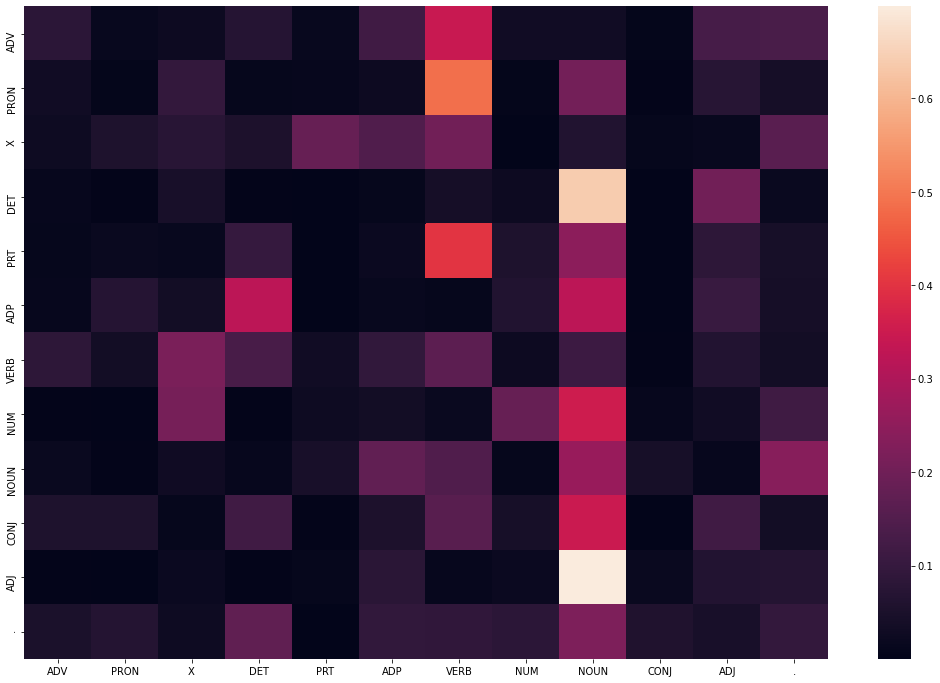

In [18]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

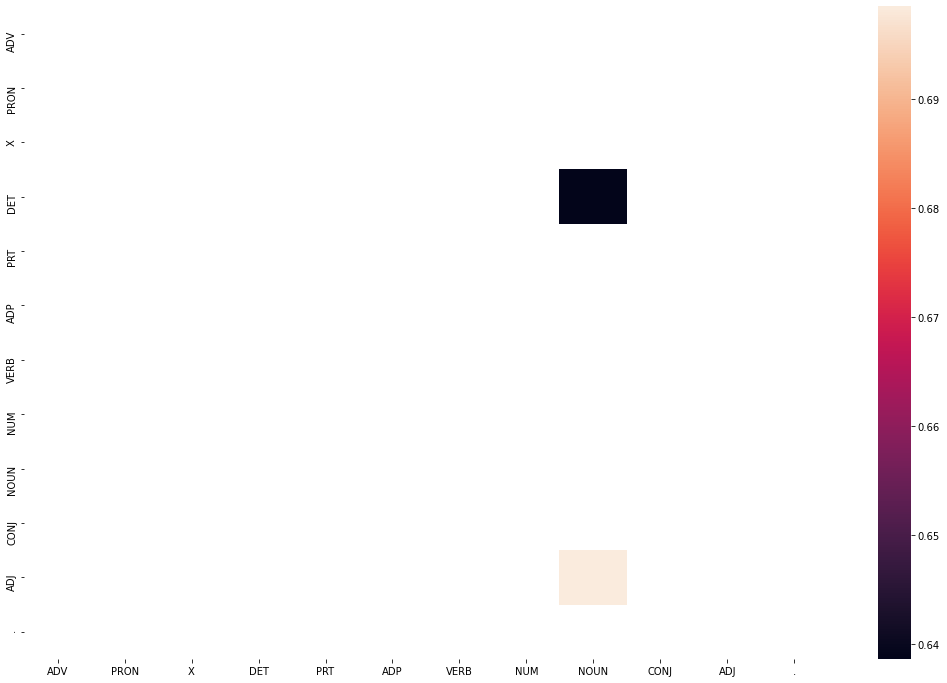

In [19]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## Viterbi Algorithm

We will use the vanilla Viterbi Algorithm using the emission and transition probability to calculate the tag of a word.

In [20]:
import functools
import time

def timer(func):
    """
    A Decorator to log the execution time of a particular function 
    """
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start = time.time()
        value = func(*args, **kwargs)
        print(f'{func.__name__} processsing finished in {time.time()-start} seconds')
        return value 
    wrapper_timer._original = func
    return wrapper_timer

# Viterbi Heuristic
@timer
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [21]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('``', '.'),
  ('When', 'ADV'),
  ('the', 'DET'),
  ('sell', 'NOUN'),
  ('programs', 'NOUN'),
  ('hit', 'VERB'),
  ('*T*-1', 'X'),
  (',', '.'),
  ('you', 'PRON'),
  ('can', 'VERB'),
  ('hear', 'VERB'),
  ('the', 'DET'),
  ('order', 'NOUN'),
  ('printers', 'NOUN'),
  ('start', 'VERB'),
  ('*-2', 'X'),
  ('to', 'PRT'),
  ('go', 'VERB'),
  ("''", '.'),
  ('on', 'ADP'),
  ('the', 'DET'),
  ('Big', 'NOUN'),
  ('Board', 'NOUN'),
  ('trading', 'NOUN'),
  ('floor', 'NOUN'),
  (',', '.'),
  ('says', 'VERB'),
  ('0', 'X'),
  ('*T*-3', 'X'),
  ('one', 'NUM'),
  ('specialist', 'NOUN'),
  ('there', 'ADV'),
  ('.', '.')],
 [('Gunmen', 'NOUN'),
  ('in', 'ADP'),
  ('Lebanon', 'NOUN'),
  ('assassinated', 'VERB'),
  ('a', 'DET'),
  ('Saudi', 'NOUN'),
  ('Arabian', 'NOUN'),
  ('Embassy', 'NOUN'),
  ('employee', 'NOUN'),
  (',', '.'),
  ('and', 'CONJ'),
  ('the', 'DET'),
  ('pro-Iranian', 'ADJ'),
  ('Islamic', 'NOUN'),
  ('Jihad', 'NOUN'),
  ('took', 'VERB'),
  ('responsibility', 'NOUN'),
  ('for', 'AD

In [22]:
# tagging the test sentences
tagged_seq = Viterbi(test_tagged_words)

Viterbi processsing finished in 20.037139654159546 seconds


In [23]:
tagged_seq[:10]

[('``', '.'),
 ('When', 'ADV'),
 ('the', 'DET'),
 ('sell', 'VERB'),
 ('programs', 'NOUN'),
 ('hit', 'VERB'),
 ('*T*-1', 'X'),
 (',', '.'),
 ('you', 'PRON'),
 ('can', 'VERB')]

In [24]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vanilla_accuracy = len(check)/len(tagged_seq)
print(f'Accuracy using Vanilla Viterbi Algorithm on Test Set: {vanilla_accuracy*100:.2f}%')

Accuracy using Vanilla Viterbi Algorithm on Test Set: 86.75%


The accuracy of the Vanilla Viterbi algorithm is limited by its vocabulary.

Lets check some incorrectly tagged cases.

In [25]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('the', 'DET'), (('sell', 'VERB'), ('sell', 'NOUN'))],
 [('order', 'NOUN'), (('printers', 'ADV'), ('printers', 'NOUN'))],
 [('specialist', 'NOUN'), (('there', 'DET'), ('there', 'ADV'))],
 [('.', '.'), (('Gunmen', 'ADV'), ('Gunmen', 'NOUN'))],
 [('in', 'ADP'), (('Lebanon', 'ADV'), ('Lebanon', 'NOUN'))],
 [('Lebanon', 'NOUN'), (('assassinated', 'ADV'), ('assassinated', 'VERB'))],
 [('Saudi', 'NOUN'), (('Arabian', 'ADV'), ('Arabian', 'NOUN'))],
 [('the', 'DET'), (('pro-Iranian', 'ADV'), ('pro-Iranian', 'ADJ'))],
 [('pro-Iranian', 'ADJ'), (('Islamic', 'ADV'), ('Islamic', 'NOUN'))],
 [('the', 'DET'), (('slaying', 'ADV'), ('slaying', 'NOUN'))],
 [('to', 'PRT'), (('avenge', 'ADV'), ('avenge', 'VERB'))],
 [('the', 'DET'), (('beheading', 'ADV'), ('beheading', 'NOUN'))],
 [('16', 'NUM'), (('terrorists', 'ADV'), ('terrorists', 'NOUN'))],
 [('by', 'ADP'), (('Riyadh', 'ADV'), ('Riyadh', 'NOUN'))],
 [('.', '.'), (('Card', 'ADV'), ('Card', 'NOUN'))],
 [('a', 'DET'), (('sweepstakes', 'ADV'), ('sweep

In [26]:
wrong_tagged_words_vanilla_vit = [j[0][0] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]
wrong_tagged_words_vanilla_vit

['sell',
 'printers',
 'there',
 'Gunmen',
 'Lebanon',
 'assassinated',
 'Arabian',
 'pro-Iranian',
 'Islamic',
 'slaying',
 'avenge',
 'beheading',
 'terrorists',
 'Riyadh',
 'Card',
 'sweepstakes',
 'forthcoming',
 '10-year',
 'yen-denominated',
 'about',
 'redeeming',
 'convert']

## Test Sentences

We will now analyze the performance of the Vanilla Viterbi algorithm on the sample test sentences.

In [27]:
# load test sentences
test_sentences_df = pd.read_csv('https://cdn.upgrad.com/UpGrad/temp/9dca5f3b-53c3-47e1-86d5-5ec5dafad6f0/Test_sentences.txt',header=None, delimiter='\n',names=  ['sentences'])
test_sentences_df

,sentences
0,Android is a mobile operating system developed...
1,Android has been the best-selling OS worldwide...
2,Google and Twitter made a deal in 2015 that ga...
3,Twitter is an online news and social networkin...
4,"Before entering politics, Donald Trump was a d..."
5,The 2018 FIFA World Cup is the 21st FIFA World...
6,This is the first World Cup to be held in East...
7,Show me the cheapest round trips from Dallas t...
8,I would like to see flights from Denver to Phi...
9,Show me the price of the flights leaving Atlan...


In [28]:
test_sentences_df['tokenized'] = test_sentences_df.sentences.apply(nltk.word_tokenize)

In [29]:
tqdm.pandas(desc='Tagging using Vanilla Viterbi')
test_sentences_df['tagged_vanilla_viterbi'] = test_sentences_df.tokenized.progress_apply(Viterbi._original)

Tagging using Vanilla Viterbi: 100%|██████████| 11/11 [00:22<00:00,  2.06s/it]


In [30]:
test_sentences_df

,sentences,tokenized,tagged_vanilla_viterbi
0,Android is a mobile operating system developed...,"[Android, is, a, mobile, operating, system, de...","[(Android, ADV), (is, VERB), (a, DET), (mobile..."
1,Android has been the best-selling OS worldwide...,"[Android, has, been, the, best-selling, OS, wo...","[(Android, ADV), (has, VERB), (been, VERB), (t..."
2,Google and Twitter made a deal in 2015 that ga...,"[Google, and, Twitter, made, a, deal, in, 2015...","[(Google, ADV), (and, CONJ), (Twitter, ADV), (..."
3,Twitter is an online news and social networkin...,"[Twitter, is, an, online, news, and, social, n...","[(Twitter, ADV), (is, VERB), (an, DET), (onlin..."
4,"Before entering politics, Donald Trump was a d...","[Before, entering, politics, ,, Donald, Trump,...","[(Before, ADP), (entering, VERB), (politics, N..."
5,The 2018 FIFA World Cup is the 21st FIFA World...,"[The, 2018, FIFA, World, Cup, is, the, 21st, F...","[(The, DET), (2018, ADV), (FIFA, ADV), (World,..."
6,This is the first World Cup to be held in East...,"[This, is, the, first, World, Cup, to, be, hel...","[(This, DET), (is, VERB), (the, DET), (first, ..."
7,Show me the cheapest round trips from Dallas t...,"[Show, me, the, cheapest, round, trips, from, ...","[(Show, NOUN), (me, PRON), (the, DET), (cheape..."
8,I would like to see flights from Denver to Phi...,"[I, would, like, to, see, flights, from, Denve...","[(I, PRON), (would, VERB), (like, ADP), (to, P..."
9,Show me the price of the flights leaving Atlan...,"[Show, me, the, price, of, the, flights, leavi...","[(Show, NOUN), (me, PRON), (the, DET), (price,..."


In [31]:
# count of words vs tags from test file
test_words = set(np.concatenate(test_sentences_df.tokenized))
word_tag_count = [(word, tag, word_given_tag(word, tag)[0]) for word in test_words for tag in T]
word_tag_count_df = pd.DataFrame.from_records(word_tag_count, columns=['word','tag','count'])
word_tag_count_df = word_tag_count_df.pivot(index='word', columns='tag', values=['count']).reset_index()
word_tag_count_df.columns = [col[1] if col[0] != 'word' else col[0] for col in word_tag_count_df.columns.values]
word_tag_count_df

,word,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
0,'s,0,0,0,0,0,0,0,0,0,726,98,0
1,",",4632,0,0,0,0,0,0,0,0,0,0,0
2,.,3637,0,0,0,0,0,0,0,0,0,0,0
3,11th,0,1,0,0,0,0,0,0,0,0,0,0
4,2011,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,which,0,0,1,0,0,215,0,0,0,0,0,0
111,with,0,0,366,0,0,0,0,0,0,0,0,0
112,worldwide,0,0,0,0,0,0,0,0,0,0,0,0
113,would,0,0,0,0,0,0,0,0,0,0,199,0


We will now identify the unknown words in comparison to the vocabulary of the Viterbi algorithm.

In [32]:
word_tag_count_df.set_index('word',inplace=True,drop=True)
unknown_words = word_tag_count_df.loc[(word_tag_count_df==0).all(axis=1)].index

In [33]:
print(f'There are {len(unknown_words)} unknown words in the Test Sentences. And they are: \n{os.linesep.join(unknown_words)}')

There are 28 unknown words in the Test Sentences. And they are: 
2011
2013
2015
2018
21st
Android
Cup
FIFA
Google
ICESAT-2
NASA
OS
Satellite
Twitter
arriving
contested
domineering
firehose
interact
invited
messages
online
personality
smartphones
tournament
trips
tweets
worldwide


In [34]:
# Check how the unknown words are being tagged by the Vanilla Viterbi Algorithm

tagged_unknown_words_vanilla =  [ word for word in test_sentences_df.tagged_vanilla_viterbi.sum() if word[0] in unknown_words]
tagged_unknown_words_vanilla

[('Android', 'ADV'),
 ('Google', 'ADV'),
 ('Android', 'ADV'),
 ('OS', 'ADV'),
 ('worldwide', 'ADV'),
 ('smartphones', 'ADV'),
 ('2011', 'ADV'),
 ('2013', 'ADV'),
 ('Google', 'ADV'),
 ('Twitter', 'ADV'),
 ('2015', 'ADV'),
 ('Google', 'ADV'),
 ('Twitter', 'ADV'),
 ('firehose', 'ADV'),
 ('Twitter', 'ADV'),
 ('online', 'ADV'),
 ('interact', 'ADV'),
 ('messages', 'ADV'),
 ('tweets', 'ADV'),
 ('domineering', 'ADV'),
 ('personality', 'ADV'),
 ('2018', 'ADV'),
 ('FIFA', 'ADV'),
 ('Cup', 'ADV'),
 ('21st', 'ADV'),
 ('FIFA', 'ADV'),
 ('Cup', 'ADV'),
 ('tournament', 'ADV'),
 ('contested', 'ADV'),
 ('Cup', 'ADV'),
 ('trips', 'ADV'),
 ('arriving', 'ADV'),
 ('NASA', 'ADV'),
 ('invited', 'ADV'),
 ('ICESAT-2', 'ADV'),
 ('Satellite', 'ADV')]

_All of the unknown words have been tagged arbitarily. In most of the cases the 1st occuring tag in the list._

This affects the performance of the Algorithm.

### Solve the problem of unknown words

We can take two approaches in solving the problem of unknown words.

1.  Rule Based:
    -   By assigning the most frequent tag in the corpus
    -   By using a Combined tagger Based on Morphological Features (such as words ending with `-ed / -ing` are VERB usually), Unigram and Bigram Taggers
2.  Probability Based
    -   For all words in the corpus, State Probability = Transition Probability * Emission Probability
    -   For words not in the corpus, State Probability = Transition Probability

## Viterbi with Rule Based Tagging

We will use Unigram and Bigram Taggers along with Regex Tagger with some morphological features to tag the unknown / out of vocabulary tokens.   

In [35]:
# Define Regex tag patterns
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'VERB'),              # modals
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                    # nouns
]

regex_tagger = nltk.RegexpTagger(patterns)
# Build a combined tagger Regex Tagging, Unigram and Bigram Tagging
def combined_tagger(train_data,taggers,backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data,backoff=backoff)
    return backoff

com_tagger = combined_tagger(train_set,
                            taggers = [nltk.UnigramTagger,nltk.BigramTagger],
                            backoff = regex_tagger
                )

In [36]:
@timer
def ViterbiWithBackoffTaggers(words,backoff_tagger = com_tagger,train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from backoff_tagger
        if word not in V:            
            unk_word_tag=backoff_tagger.tag([word])[0][1]
            state.append(unk_word_tag)
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))


#### Evaluating tagging accuracy

In [37]:
tagged_seq = ViterbiWithBackoffTaggers(test_tagged_words,com_tagger)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
backoff_accuracy = len(check)/len(tagged_seq)
print(f'Accuracy using Viterbi Algorithm with Backoff Tagger on Test Set: {backoff_accuracy*100:.2f}%')

ViterbiWithBackoffTaggers processsing finished in 18.179633617401123 seconds
Accuracy using Viterbi Algorithm with Backoff Tagger on Test Set: 92.77%


Lets check the incorrectly tagged cases by the Backoff Tagger.

In [38]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('the', 'DET'), (('sell', 'VERB'), ('sell', 'NOUN'))],
 [('specialist', 'NOUN'), (('there', 'DET'), ('there', 'ADV'))],
 [('the', 'DET'), (('pro-Iranian', 'NOUN'), ('pro-Iranian', 'ADJ'))],
 [('the', 'DET'), (('slaying', 'VERB'), ('slaying', 'NOUN'))],
 [('to', 'PRT'), (('avenge', 'NOUN'), ('avenge', 'VERB'))],
 [('the', 'DET'), (('beheading', 'VERB'), ('beheading', 'NOUN'))],
 [('a', 'DET'), (('sweepstakes', 'VERB'), ('sweepstakes', 'NOUN'))],
 [('The', 'DET'), (('forthcoming', 'VERB'), ('forthcoming', 'ADJ'))],
 [('a', 'DET'), (('10-year', 'ADJ'), ('10-year', 'NUM'))],
 [('government', 'NOUN'),
  (('yen-denominated', 'VERB'), ('yen-denominated', 'ADJ'))],
 [('at', 'ADP'), (('about', 'ADP'), ('about', 'ADV'))],
 [('will', 'VERB'), (('convert', 'NOUN'), ('convert', 'VERB'))]]

In [39]:
wrong_tagged_words_backoff = [j[0][0] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]
wrong_tagged_words_backoff

['sell',
 'there',
 'pro-Iranian',
 'slaying',
 'avenge',
 'beheading',
 'sweepstakes',
 'forthcoming',
 '10-year',
 'yen-denominated',
 'about',
 'convert']

In [40]:
tqdm.pandas(desc='Tagging using Viterbi with Backoff Taggers')
test_sentences_df['tagged_backoff_viterbi'] = test_sentences_df.tokenized.progress_apply(ViterbiWithBackoffTaggers._original)

Tagging using Viterbi with Backoff Taggers: 100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


In [41]:
# Check how the unknown words are being tagged by the Vanilla Viterbi Algorithm

tagged_unknown_words_backoff =  [ word for word in test_sentences_df.tagged_backoff_viterbi.sum() if word[0] in unknown_words]
tagged_unknown_words_backoff

[('Android', 'NOUN'),
 ('Google', 'NOUN'),
 ('Android', 'NOUN'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('smartphones', 'VERB'),
 ('2011', 'NUM'),
 ('2013', 'NUM'),
 ('Google', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('2015', 'NUM'),
 ('Google', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('firehose', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('online', 'NOUN'),
 ('interact', 'NOUN'),
 ('messages', 'VERB'),
 ('tweets', 'NOUN'),
 ('domineering', 'VERB'),
 ('personality', 'NOUN'),
 ('2018', 'NUM'),
 ('FIFA', 'NOUN'),
 ('Cup', 'NOUN'),
 ('21st', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('Cup', 'NOUN'),
 ('tournament', 'NOUN'),
 ('contested', 'VERB'),
 ('Cup', 'NOUN'),
 ('trips', 'NOUN'),
 ('arriving', 'VERB'),
 ('NASA', 'NOUN'),
 ('invited', 'VERB'),
 ('ICESAT-2', 'NOUN'),
 ('Satellite', 'NOUN')]

## Viterbi with Probability based switch

-   For all words in the corpus, State Probability = Transition Probability * Emission Probability
-   For words not in the corpus, State Probability = Transition Probability

In [42]:
@timer
def ViterbiWithProbabilitySwitch(words,train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            # Handle out of Vocabulary words by only considering the transition probabilty when emission probability is 0.
            if word not in V: 
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p    
            p.append(state_probability)
        
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
            
    return list(zip(words, state))


In [43]:
tagged_seq = ViterbiWithProbabilitySwitch(test_tagged_words)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
prob_based_accuracy = len(check)/len(tagged_seq) 
print(f'Accuracy using Viterbi Algorithm with Probability based Switch on Test Set: {prob_based_accuracy*100:.2f}%')

ViterbiWithProbabilitySwitch processsing finished in 20.953309535980225 seconds
Accuracy using Viterbi Algorithm with Probability based Switch on Test Set: 92.17%


In [44]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('the', 'DET'), (('sell', 'VERB'), ('sell', 'NOUN'))],
 [('specialist', 'NOUN'), (('there', 'DET'), ('there', 'ADV'))],
 [('in', 'ADP'), (('Lebanon', 'DET'), ('Lebanon', 'NOUN'))],
 [('Lebanon', 'NOUN'), (('assassinated', 'NOUN'), ('assassinated', 'VERB'))],
 [('the', 'DET'), (('pro-Iranian', 'NOUN'), ('pro-Iranian', 'ADJ'))],
 [('by', 'ADP'), (('Riyadh', 'DET'), ('Riyadh', 'NOUN'))],
 [('Riyadh', 'NOUN'), (("'s", 'VERB'), ("'s", 'PRT'))],
 [('The', 'DET'), (('forthcoming', 'NOUN'), ('forthcoming', 'ADJ'))],
 [('a', 'DET'), (('10-year', 'ADJ'), ('10-year', 'NUM'))],
 [('government', 'NOUN'),
  (('yen-denominated', 'NOUN'), ('yen-denominated', 'ADJ'))],
 [('at', 'ADP'), (('about', 'ADP'), ('about', 'ADV'))],
 [('investors', 'NOUN'), (('redeeming', 'NOUN'), ('redeeming', 'VERB'))],
 [('will', 'VERB'), (('convert', 'X'), ('convert', 'VERB'))]]

In [45]:
wrong_tagged_words_prob_based = [j[0][0] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]
wrong_tagged_words_prob_based

['sell',
 'there',
 'Lebanon',
 'assassinated',
 'pro-Iranian',
 'Riyadh',
 "'s",
 'forthcoming',
 '10-year',
 'yen-denominated',
 'about',
 'redeeming',
 'convert']

In [46]:
tqdm.pandas(desc='Tagging using Viterbi with Backoff Taggers')
test_sentences_df['tagged_prob_viterbi'] = test_sentences_df.tokenized.progress_apply(ViterbiWithProbabilitySwitch._original)

Tagging using Viterbi with Backoff Taggers: 100%|██████████| 11/11 [00:23<00:00,  2.12s/it]


In [47]:
# Check how the unknown words are being tagged by the Vanilla Viterbi Algorithm

tagged_unknown_words_prob =  [ word for word in test_sentences_df.tagged_prob_viterbi.sum() if word[0] in unknown_words]
tagged_unknown_words_prob

[('Android', 'NOUN'),
 ('Google', 'DET'),
 ('Android', 'NOUN'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('smartphones', 'DET'),
 ('2011', 'DET'),
 ('2013', 'DET'),
 ('Google', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('2015', 'DET'),
 ('Google', 'X'),
 ('Twitter', 'VERB'),
 ('firehose', 'VERB'),
 ('Twitter', 'NOUN'),
 ('online', 'NOUN'),
 ('interact', 'NOUN'),
 ('messages', 'DET'),
 ('tweets', 'DET'),
 ('domineering', 'NOUN'),
 ('personality', 'NOUN'),
 ('2018', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('Cup', 'NOUN'),
 ('21st', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('Cup', 'NOUN'),
 ('tournament', 'NOUN'),
 ('contested', 'NOUN'),
 ('Cup', 'NOUN'),
 ('trips', 'NOUN'),
 ('arriving', 'NOUN'),
 ('NASA', 'NOUN'),
 ('invited', 'NOUN'),
 ('ICESAT-2', 'DET'),
 ('Satellite', 'NOUN')]

## Analysis of incorrect tagged words

by the Vanilla Viterbi, Back off Tagging Method and Probability based Tagging Method 

In [48]:
print(f'No. of wrong taggings by Vanilla Viterbi Algorithm: {len(wrong_tagged_words_vanilla_vit)}')
print(f'No. of wrong taggings by Viterbi Algorithm with Backoff: {len(wrong_tagged_words_backoff)}')
print(f'No. of wrong taggings by Viterbi Algorithm with probability based approach: {len(wrong_tagged_words_prob_based)}')

No. of wrong taggings by Vanilla Viterbi Algorithm: 22
No. of wrong taggings by Viterbi Algorithm with Backoff: 12
No. of wrong taggings by Viterbi Algorithm with probability based approach: 13


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [49]:
accuracies_df = pd.DataFrame([vanilla_accuracy,backoff_accuracy,prob_based_accuracy],
                            index = ['Vanilla Viterbi','Viterbi with Backoff Tagger','Viterbi with Probability Based Tagging'],
                            columns = ['accuracy'])

In [56]:
accuracies_df.sort_values(by='accuracy')

,accuracy
Vanilla Viterbi,0.867470
Viterbi with Probability Based Tagging,0.921687
Viterbi with Backoff Tagger,0.927711


With the two implemented modifications to the Vanilla Viterbi Algorithm, we see a considerable jump in accuracy.
-   Using the Viterbi with backoff taggers, we were able to achieve `92.77 %` accuracy from 86.14% using Vanilla Viterbi.
-   Using the Viterbi with probability based tagging, we were able to achieve `92.17 %` accuracy.

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [51]:
test_sentences_df

,sentences,tokenized,tagged_vanilla_viterbi,tagged_backoff_viterbi,tagged_prob_viterbi
0,Android is a mobile operating system developed...,"[Android, is, a, mobile, operating, system, de...","[(Android, ADV), (is, VERB), (a, DET), (mobile...","[(Android, NOUN), (is, VERB), (a, DET), (mobil...","[(Android, NOUN), (is, VERB), (a, DET), (mobil..."
1,Android has been the best-selling OS worldwide...,"[Android, has, been, the, best-selling, OS, wo...","[(Android, ADV), (has, VERB), (been, VERB), (t...","[(Android, NOUN), (has, VERB), (been, VERB), (...","[(Android, NOUN), (has, VERB), (been, VERB), (..."
2,Google and Twitter made a deal in 2015 that ga...,"[Google, and, Twitter, made, a, deal, in, 2015...","[(Google, ADV), (and, CONJ), (Twitter, ADV), (...","[(Google, NOUN), (and, CONJ), (Twitter, NOUN),...","[(Google, NOUN), (and, CONJ), (Twitter, NOUN),..."
3,Twitter is an online news and social networkin...,"[Twitter, is, an, online, news, and, social, n...","[(Twitter, ADV), (is, VERB), (an, DET), (onlin...","[(Twitter, NOUN), (is, VERB), (an, DET), (onli...","[(Twitter, NOUN), (is, VERB), (an, DET), (onli..."
4,"Before entering politics, Donald Trump was a d...","[Before, entering, politics, ,, Donald, Trump,...","[(Before, ADP), (entering, VERB), (politics, N...","[(Before, ADP), (entering, VERB), (politics, N...","[(Before, ADP), (entering, VERB), (politics, N..."
5,The 2018 FIFA World Cup is the 21st FIFA World...,"[The, 2018, FIFA, World, Cup, is, the, 21st, F...","[(The, DET), (2018, ADV), (FIFA, ADV), (World,...","[(The, DET), (2018, NUM), (FIFA, NOUN), (World...","[(The, DET), (2018, NOUN), (FIFA, NOUN), (Worl..."
6,This is the first World Cup to be held in East...,"[This, is, the, first, World, Cup, to, be, hel...","[(This, DET), (is, VERB), (the, DET), (first, ...","[(This, DET), (is, VERB), (the, DET), (first, ...","[(This, DET), (is, VERB), (the, DET), (first, ..."
7,Show me the cheapest round trips from Dallas t...,"[Show, me, the, cheapest, round, trips, from, ...","[(Show, NOUN), (me, PRON), (the, DET), (cheape...","[(Show, NOUN), (me, PRON), (the, DET), (cheape...","[(Show, NOUN), (me, PRON), (the, DET), (cheape..."
8,I would like to see flights from Denver to Phi...,"[I, would, like, to, see, flights, from, Denve...","[(I, PRON), (would, VERB), (like, ADP), (to, P...","[(I, PRON), (would, VERB), (like, ADP), (to, P...","[(I, PRON), (would, VERB), (like, ADP), (to, P..."
9,Show me the price of the flights leaving Atlan...,"[Show, me, the, price, of, the, flights, leavi...","[(Show, NOUN), (me, PRON), (the, DET), (price,...","[(Show, NOUN), (me, PRON), (the, DET), (price,...","[(Show, NOUN), (me, PRON), (the, DET), (price,..."


We will print and compare the original sentence along with the tagging results from the different taggers.

In [52]:
def print_tagger_results(row):
    print()
    print('Original Sentence:')
    print('------------------')
    print(row.sentences,'\n')

    print('Tagged with Vanilla Viterbi')
    print('---------------------------')
    print(*row.tagged_vanilla_viterbi,'\n')

    print('Tagged with Viterbi with Backoff')
    print('--------------------------------')
    print(*row.tagged_backoff_viterbi,'\n')

    print('Tagged with Viterbi with Probability Based Switch')
    print('-------------------------------------------------')
    print(*row.tagged_prob_viterbi,'\n')
    print()
  

In [53]:
# test_sentences_df.apply(lambda row: print_tagger_results(row),axis=1)
tqdm.pandas(desc = 'Compare the Taggers')
test_sentences_df.progress_apply(print_tagger_results,axis=1)

Compare the Taggers:   0%|          | 0/11 [00:00<?, ?it/s]
Original Sentence:
------------------
Android is a mobile operating system developed by Google. 

Tagged with Vanilla Viterbi
---------------------------
('Android', 'ADV') ('is', 'VERB') ('a', 'DET') ('mobile', 'ADJ') ('operating', 'NOUN') ('system', 'NOUN') ('developed', 'VERB') ('by', 'ADP') ('Google', 'ADV') ('.', '.') 

Tagged with Viterbi with Backoff
--------------------------------
('Android', 'NOUN') ('is', 'VERB') ('a', 'DET') ('mobile', 'ADJ') ('operating', 'NOUN') ('system', 'NOUN') ('developed', 'VERB') ('by', 'ADP') ('Google', 'NOUN') ('.', '.') 

Tagged with Viterbi with Probability Based Switch
-------------------------------------------------
('Android', 'NOUN') ('is', 'VERB') ('a', 'DET') ('mobile', 'ADJ') ('operating', 'NOUN') ('system', 'NOUN') ('developed', 'VERB') ('by', 'ADP') ('Google', 'DET') ('.', '.') 



Original Sentence:
------------------
Android has been the best-selling OS worldwide on smartpho

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
dtype: object

### Compare unknown words tagging

Compare the tagging side by side

In [54]:
tagged_unknown_words_df = pd.DataFrame(tagged_unknown_words_vanilla,columns=['word','vanilla_tag'])
tagged_unknown_words_backoff_df = pd.DataFrame(tagged_unknown_words_backoff,columns=['word','backoff_tag'])
tagged_unknown_words_prob_df = pd.DataFrame(tagged_unknown_words_prob,columns=['word','probabilty_based_tag'])

In [55]:
# Set Pandas style attribute to display the dataframes side by side
from IPython.display import display_html 


tagged_unknown_words_df_styler = tagged_unknown_words_df.style.set_table_attributes("style='display:inline'").set_caption('tagged_unknown_words_df')
tagged_unknown_words_backoff_df_styler = tagged_unknown_words_backoff_df.style.set_table_attributes("style='display:inline'").set_caption('tagged_unknown_words_backoff_df')
tagged_unknown_words_prob_df_styler = tagged_unknown_words_prob_df.style.set_table_attributes("style='display:inline'").set_caption('tagged_unknown_words_prob_df')

space = "\xa0" * 10

display_html(tagged_unknown_words_df_styler._repr_html_()+space+tagged_unknown_words_backoff_df_styler._repr_html_()+space+tagged_unknown_words_prob_df_styler._repr_html_(), raw=True)

,word,vanilla_tag
0,Android,ADV
1,Google,ADV
2,Android,ADV
3,OS,ADV
4,worldwide,ADV
5,smartphones,ADV
6,2011,ADV
7,2013,ADV
8,Google,ADV
9,Twitter,ADV


Some sample corrections using our modifications that standout are:

1. `Android` are now being being tagged as `NOUN` (originally tagged arbitrarily).
2. `arriving` are now being being tagged as `VERB` (originally tagged arbitrarily).
3. `2011`, `2013` are now being tagged as `NUM`. (originally tagged arbitrarily)


The modifications clearly help the vanilla viterbi algorithm to tag the unknown words in a better way.